In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image

# Path to your dataset folder (update if needed)
dataset_path = "./Images"

# Verify the dataset path
if not os.path.exists(dataset_path):
    print(f"The dataset path {dataset_path} doesn't exist!")
else:
    print("Dataset found!")

Dataset found!


In [9]:
# Load and preprocess the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize parameters
IMG_HEIGHT, IMG_WIDTH = 32, 32  # Resize images to 32x32
NUM_CLASSES = 43  # Total number of traffic sign classes

data = []
labels = []

for label in range(NUM_CLASSES):
    label_path = os.path.join(dataset_path, str(label))
    if os.path.exists(label_path):
        for file in os.listdir(label_path):
            try:
                image = Image.open(os.path.join(label_path, file)).convert("RGB")
                image = image.resize((IMG_WIDTH, IMG_HEIGHT))
                data.append(np.array(image))
                labels.append(label)
            except Exception as e:
                print(f"Error loading image: {file}, error: {e}")

data = np.array(data) / 255.0  # Normalize the data
labels = to_categorical(np.array(labels), NUM_CLASSES)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Fit data generator to training data
datagen.fit(X_train)


In [10]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

# Define the CNN model
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),  # Explicitly specify input shape
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,963 (1.38 MB)

 Trainable params: 361,515 (1.38 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Use augmented data
    epochs=430,  # Increase the number of epochs
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/430
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8905 - loss: 0.6348 - val_accuracy: 0.9028 - val_loss: 0.5553
Epoch 2/430
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.8952 - loss: 0.6010 - val_accuracy: 0.9039 - val_loss: 0.5588
Epoch 3/430
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8960 - loss: 0.5963 - val_accuracy: 0.8815 - val_loss: 0.6221
Epoch 4/430
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8850 - loss: 0.6456 - val_accuracy: 0.8996 - val_loss: 0.5856
Epoch 5/430
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8879 - loss: 0.6219 - val_accuracy: 0.8922 - val_loss: 0.5947
Epoch 6/430
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8783 - loss: 0.6575 - val_accuracy: 0.9007 - val_loss: 0.5879
Epoch 7/430
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8824 - loss: 0.6331 - val_accuracy: 0.9044 - val_loss: 0.5572
Epoch 8/430
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8822 - loss: 0

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8891 - loss: 0.5618
Test Accuracy: 89.96%


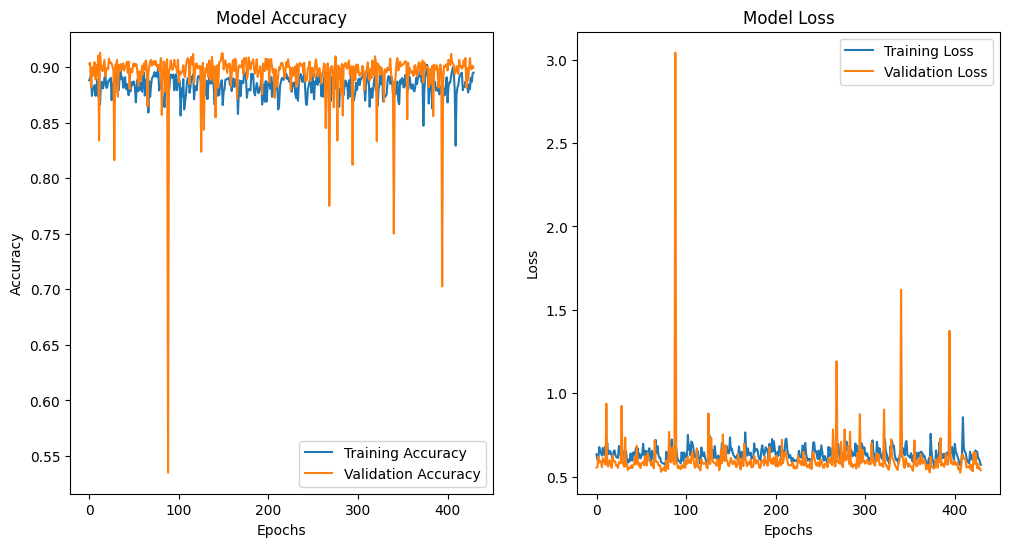

In [18]:
import matplotlib.pyplot as plt

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


ValueError: The number of FixedLocator locations (42), usually from a call to set_ticks, does not match the number of labels (43).

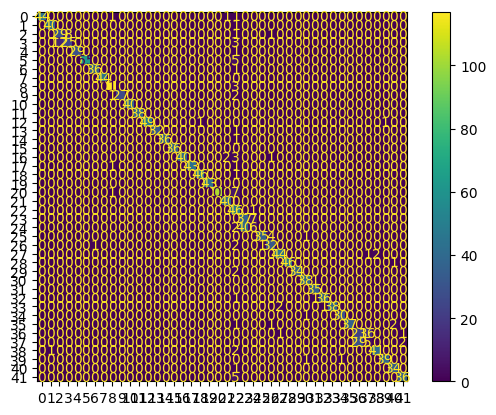

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(NUM_CLASSES))
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8891 - loss: 0.5618
Test Accuracy: 89.96%


In [20]:
model.save("traffic_sign_90_classifier.h5")
print("Model saved as traffic_sign_classifier.h5")


Model saved as traffic_sign_classifier.h5


In [21]:
model.save("traffic_sign_90_classifier.keras")
print("Model saved as traffic_sign_classifier.keras")

Model saved as traffic_sign_classifier.keras
